<a href="https://colab.research.google.com/github/ricpdc/QSPL-Survey/blob/main/QSE_Survey_Analysis_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# QSE Hybrid Systems Survey — Reproducible Analysis (Colab)

**Project:** Validation of a Feature Model for Hybrid Quantum–Classical Systems (QSE)  
**Goal:** Load Google Sheets survey responses, clean data, produce tables/figures, and compute basic statistics (incl. reliability for Likert constructs), enabling a **re-runnable** pipeline as more responses arrive.

**Last updated:** 2025-10-02 06:32 UTC  
**Author(s):** _Add names here_

---

## How to use this notebook

1. Ensure the survey Google Sheet is shared appropriately (see **Config** cell).  
2. Run the notebook top-to-bottom.  
3. All figures and tables are written to `/content/outputs` in Colab (or the `outputs` folder if you mount Drive).  
4. The notebook is structured to be **self-contained and re-runnable**; you can refresh results as new responses arrive.


## 1. Runtime & libraries

In [1]:

#@title Install and import libraries
# If you need pinned versions, uncomment the pip cell and pin accordingly.
# %%capture
# !pip install pandas==2.2.2 numpy==2.0.2 matplotlib==3.9.0 scipy==1.13.1 statsmodels==0.14.2 gspread==6.1.4 gspread-dataframe==3.3.1

import os
import io
import sys
import json
import math
from pathlib import Path
from typing import List, Dict, Tuple

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# (Optional) stats
import scipy.stats as stats
import statsmodels.api as sm

# (Optional) Google Sheets API
try:
    import gspread
    from gspread_dataframe import get_as_dataframe
    HAS_GSPREAD = True
except Exception as e:
    HAS_GSPREAD = False

print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('matplotlib:', plt.matplotlib.__version__)
print('scipy:', stats.__version__ if hasattr(stats, '__version__') else 'n/a')
print('statsmodels:', sm.__version__)
print('gspread available:', HAS_GSPREAD)


pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0
scipy: n/a
statsmodels: 0.14.5
gspread available: True


## 2. Configuration (Google Sheets & paths)

In [2]:

#@title Configuration
from dataclasses import dataclass

# === Google Sheets ===
# Use the SHEET_ID from the spreadsheet URL:
# Example: https://docs.google.com/spreadsheets/d/<<SHEET_ID>>/edit?usp=sharing
SHEET_ID = "1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM"  # Provided by the project owner
# Optionally specify the GID for each sheet/tab if needed. The default (0) is often the first tab.
# You can find GID by opening the specific tab and reading the 'gid=<NUMBER>' param in the URL.
PRIMARY_GID = 0  # Change if your responses are in another tab

# === Access method ===
ACCESS_METHOD = "csv_export"  #@param ["csv_export", "gspread_oauth"]
# - "csv_export": uses public CSV export (Sheet must be at least 'Anyone with the link: Viewer')
# - "gspread_oauth": uses interactive OAuth in Colab (no need to make sheet public)

# === Paths ===
BASE_DIR = Path("/content")
OUTPUT_DIR = BASE_DIR / "outputs"
CACHE_DIR = BASE_DIR / "cache"
for d in (OUTPUT_DIR, CACHE_DIR):
    d.mkdir(parents=True, exist_ok=True)

# === Optional: Mount Google Drive ===
MOUNT_DRIVE = False  #@param {type:"boolean"}
if MOUNT_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    # Redirect outputs if desired:
    # OUTPUT_DIR = Path('/content/drive/MyDrive/qse_survey/outputs')
    # OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('OUTPUT_DIR:', OUTPUT_DIR)
print('CACHE_DIR:', CACHE_DIR)
print('ACCESS_METHOD:', ACCESS_METHOD)


OUTPUT_DIR: /content/outputs
CACHE_DIR: /content/cache
ACCESS_METHOD: csv_export


## 3. Data loading

In [3]:
#@title Helper functions to load Google Sheets (robust)
import urllib.error
import urllib.parse
import urllib.request
import pandas as pd

def sheets_csv_url(sheet_id: str, gid: int = 0) -> str:
    return f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

def sheets_gviz_url_by_sheetname(sheet_id: str, sheet_name: str) -> str:
    # GVIZ endpoint supports selecting a tab by name
    # t q x = out:csv  (forces CSV)
    from urllib.parse import quote
    return f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={quote(sheet_name)}"

def try_read_csv(url: str) -> pd.DataFrame:
    # Give a clearer error if 400/403/404
    try:
        return pd.read_csv(url)
    except urllib.error.HTTPError as e:
        print(f"[ERROR] HTTPError {e.code} for URL: {url}")
        if e.code in (400, 403):
            print("This often means the sheet is not shared publicly OR the gid/sheet name is wrong.")
        raise
    except Exception as ex:
        print(f"[ERROR] Could not read CSV: {ex}")
        raise

def load_from_csv_export(sheet_id: str, gid: int = 0) -> pd.DataFrame:
    url = sheets_csv_url(sheet_id, gid)
    print("Attempting CSV export via gid:", gid)
    print("URL:", url)
    df = try_read_csv(url)
    return df

def load_from_gviz_by_sheetname(sheet_id: str, sheet_name: str) -> pd.DataFrame:
    url = sheets_gviz_url_by_sheetname(sheet_id, sheet_name)
    print("Attempting GVIZ CSV via sheet name:", sheet_name)
    print("URL:", url)
    df = try_read_csv(url)
    return df

def load_from_gspread(sheet_id: str, worksheet_index: int = 0) -> pd.DataFrame:
    assert HAS_GSPREAD, "gspread is not available. Install it and set ACCESS_METHOD='gspread_oauth'."
    print("Using gspread OAuth. You may be prompted to authorize.")
    gc = gspread.oauth()  # Will prompt in Colab the first time
    sh = gc.open_by_key(sheet_id)
    ws = sh.get_worksheet(worksheet_index)
    df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    # Clean all-null columns that may appear due to trailing columns
    if df.shape[1] > 0 and df.columns[-1] is None:
        df = df.iloc[:, :-1]
    return df

# Optional diagnostics: list worksheets if OAuth is available
def list_worksheets(sheet_id: str):
    if not HAS_GSPREAD:
        print("[INFO] gspread is not installed/available; cannot list worksheets.")
        return None
    try:
        gc = gspread.oauth()
        sh = gc.open_by_key(sheet_id)
        tabs = [ws.title for ws in sh.worksheets()]
        print("Worksheets:", tabs)
        return tabs
    except Exception as e:
        print("[WARN] Could not list worksheets via gspread:", e)
        return None

# ---- Main loading logic ----
# You can specify SHEET_NAME if you know the tab name (e.g., 'Form Responses 1').
SHEET_NAME = "data"  # o "Form Responses 1" según tu caso

df_raw = None
if ACCESS_METHOD == "csv_export":
    try:
        df_raw = load_from_csv_export(SHEET_ID, PRIMARY_GID)
    except Exception as e:
        print("\n[HINT] CSV export failed. Common causes:")
        print("- The spreadsheet (or that tab) is not shared as 'Anyone with the link: Viewer'.")
        print("- 'PRIMARY_GID' does not match the actual tab's gid.")
        print("- For private data, switch to ACCESS_METHOD='gspread_oauth'.")
        if SHEET_NAME:
            print("\nTrying GVIZ endpoint with SHEET_NAME...")
            df_raw = load_from_gviz_by_sheetname(SHEET_ID, SHEET_NAME)
        else:
            print("\nYou can set SHEET_NAME='Form Responses 1' (or your tab's name) and re-run to try GVIZ.")
            raise
elif ACCESS_METHOD == "gspread_oauth":
    df_raw = load_from_gspread(SHEET_ID, worksheet_index=0)
else:
    raise ValueError("ACCESS_METHOD must be one of: 'csv_export', 'gspread_oauth'")

print("Shape:", df_raw.shape)
df_raw.head(3)


Attempting CSV export via gid: 0
URL: https://docs.google.com/spreadsheets/d/1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM/export?format=csv&gid=0
[ERROR] HTTPError 400 for URL: https://docs.google.com/spreadsheets/d/1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM/export?format=csv&gid=0
This often means the sheet is not shared publicly OR the gid/sheet name is wrong.

[HINT] CSV export failed. Common causes:
- The spreadsheet (or that tab) is not shared as 'Anyone with the link: Viewer'.
- 'PRIMARY_GID' does not match the actual tab's gid.
- For private data, switch to ACCESS_METHOD='gspread_oauth'.

Trying GVIZ endpoint with SHEET_NAME...
Attempting GVIZ CSV via sheet name: data
URL: https://docs.google.com/spreadsheets/d/1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM/gviz/tq?tqx=out:csv&sheet=data
Shape: (23, 99)


,timestamp,SPL_familiar,gen_funct,f_funct_classical_functionality,f_funct_quantum_functionality,f_funct_gate_based,f_funct_adiabatic,alter_funct,gen_algo,f_algo_ftqc,...,exp_q,exp_spl,qc_areas,anon,first_name,last_name,title,affiliation,country,email
0,1/09/2025 8:55:10,No (but I’d like a brief explanation before co...,Yes,5.0,3.0,4.0,1.0,NaN,Partially,NaN,...,Intermediate (1-3 years),Beginner (0-1 years),Quantum Software Engineering,"Yes, I would like to be recognized.",Alexander,Weinert,Dr.,"German Aerospace Center (DLR), Institute of So...",Germany,alexander.weinert@dlr.de
1,3/09/2025 9:56:20,Yes,Yes,5.0,5.0,5.0,2.0,NaN,Yes,4.0,...,Advanced (3-5 years),Expert (7+ years),"Quantum Software Engineering, Hybrid Classical...","Yes, I would like to be recognized.",Mohammad Reza,Mousavi,Prof.,King's College London,NaN,NaN
2,4/09/2025 11:07:53,Yes,Partially,NaN,NaN,NaN,NaN,Quantum and classical parts of a hybrid optimi...,Partially,NaN,...,Advanced (3-5 years),Intermediate (1-3 years),"Quantum Software Engineering, Hybrid Classical...","No, let’s go to the end.",NaN,NaN,NaN,NaN,NaN,NaN


## 4. Data dictionary & pre-cleaning

In [4]:
# Convertir la lista de tuplas a un diccionario
DATA_DICTIONARY = dict([
    ("timestamp", "datetime"),
    ("SPL_familiar", "boolean"),
    ("gen_funct", "likert3"),
    ("f_funct_classical_functionality", "likert5"),
    ("f_funct_quantum_functionality", "likert5"),
    ("f_funct_gate_based", "likert5"),
    ("f_funct_adiabatic", "likert5"),
    ("alter_funct", "string"),
    ("gen_algo", "likert3"),
    ("f_algo_ftqc", "likert5"),
    ("f_algo_ftqc_deutsch_jozsa", "likert5"),
    ("f_algo_ftqc_bernstein_varizani", "likert5"),
    ("f_algo_ftqc_grover", "likert5"),
    ("f_algo_ftqc_simon", "likert5"),
    ("f_algo_ftqc_shor", "likert5"),
    ("f_algo_ftqc_qft", "likert5"),
    ("f_algo_ftqc_qpe", "likert5"),
    ("f_algo_ftqc_hhl", "likert5"),
    ("f_algo_nisq", "likert5"),
    ("f_algo_nisq_qaoa", "likert5"),
    ("f_algo_nisq_vqe", "likert5"),
    ("f_algo_nisq_qml", "likert5"),
    ("f_algo_hybrid", "likert5"),
    ("f_algo_hybrid_q_as_annealing", "likert5"),
    ("f_algo_hybrid_clustering", "likert5"),
    ("f_algo_hybrid_qaoa", "likert5"),
    ("f_algo_classical_algorithm", "likert5"),
    ("c_algo_1", "likert5"),
    ("alter_algo", "string"),
    ("gen_lang", "likert3"),
    ("f_lang_quantum_framework", "likert5"),
    ("f_lang_qiskit", "likert5"),
    ("f_lang_ocean_sdk", "likert5"),
    ("f_lang_cirq", "likert5"),
    ("f_lang_braket_sdk", "likert5"),
    ("f_lang_quantum_language", "likert5"),
    ("f_lang_qasm", "likert5"),
    ("f_lang_q_sharp", "likert5"),
    ("f_lang_classical_language", "likert5"),
    ("f_lang_python", "likert5"),
    ("f_lang_c_sharp", "likert5"),
    ("c_lang_1", "likert5"),
    ("c_lang_2", "likert5"),
    ("c_lang_3", "likert5"),
    ("c_lang_4", "likert5"),
    ("alter_lang", "string"),
    ("gen_hw", "likert3"),
    ("f_hw_error_correction", "likert5"),
    ("f_hw_active_error_correction", "likert5"),
    ("f_hw_surface_code", "likert5"),
    ("f_hw_bacon_shor_code", "likert5"),
    ("f_hw_ldpc_code", "likert5"),
    ("f_hw_error_mitigation", "likert5"),
    ("f_hw_zero_noise_extrapolation", "likert5"),
    ("f_hw_readout_mitigation", "likert5"),
    ("f_hw_probabilistic_error_cancellation", "likert5"),
    ("f_hw_native_gate_set", "likert5"),
    ("f_hw_single_qubit_gate", "likert5"),
    ("f_hw_two_qubits_gate", "likert5"),
    ("f_hw_pulse_control", "likert5"),
    ("alter_hw", "string"),
    ("gen_integ", "likert3"),
    ("f_integ_qcp_aa_s", "likert5"),
    ("f_integ_qf_aa_s", "likert5"),
    ("f_integ_orch_workflows", "likert5"),
    ("c_integ_1", "likert5"),
    ("alter_integ", "string"),
    ("ccc_funct_1", "likert3"),
    ("ccc_funct_2", "likert3"),
    ("ccc_algo_1", "likert3"),
    ("ccc_algo_2", "likert3"),
    ("ccc_algo_3", "likert3"),
    ("ccc_algo_4", "likert3"),
    ("ccc_lang_1", "likert3"),
    ("ccc_lang_2", "likert3"),
    ("ccc_lang_3", "likert3"),
    ("ccc_lang_4", "likert3"),
    ("ccc_lang_5", "likert3"),
    ("ccc_hw_1", "likert3"),
    ("ccc_hw_2", "likert3"),
    ("ccc_hw_3", "likert3"),
    ("ccc_integ_1", "likert3"),
    ("ccc_integ_2", "likert3"),
    ("ccc_integ_3", "likert3"),
    ("alter_ccc", "string"),
    ("alter_gen", "string"),
    ("phase", "category"),
    ("stars", "likert5"),
    ("role", "category"),
    ("exp_q", "category"),
    ("exp_spl", "category"),
    ("qc_areas", "category"),
    ("anon", "boolean"),
    ("first_name", "string"),
    ("last_name", "string"),
    ("title", "string"),
    ("affiliation", "string"),
    ("country", "category"),
    ("email", "string")
])

In [5]:

# Mapeo para los valores textuales de Likert (convertir en enteros)
LIKERT_5 = {
    "DK/NA": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
}

LIKERT_3 = {
    "DK/NA": 0,
    "No": 1,
    "Partially": 2,
    "Yes": 3,
}

# Función para mapear y limpiar las columnas
def canonicalize_columns(df: pd.DataFrame, dictionary: dict) -> pd.DataFrame:
    out = df.copy()
    for raw, typ in dictionary.items():
        if raw not in out.columns:
            print(f"[WARN] Missing expected column in sheet: {raw}")
            continue
        new = raw  # Usamos el nombre original de la columna
        out = out.rename(columns={raw: new})

        # Procesamiento de tipos
        if typ == "datetime":
            out[new] = pd.to_datetime(out[new], errors="coerce")
        elif typ == "numeric":
            out[new] = pd.to_numeric(out[new], errors="coerce")
        elif typ == "category":
            out[new] = out[new].astype("category")
        elif typ == "likert5":
            out[new] = out[new]
            # Solo reemplazamos NaN por 0, sin afectar los valores ya existentes (1, 2, 3, etc.)
            out[new] = pd.to_numeric(out[new], errors="coerce").fillna(0).astype("Int64")  # Usar 0 para NaNs
        elif typ == "likert3":
            # Solución para mapeo en likert3: reemplazar valores desconocidos por 0
            out[new] = out[new].apply(lambda x: LIKERT_3.get(x, 0)).astype("Int64")  # Usar 0 para valores no mapeados
        elif typ == "boolean":
            out[new] = out[new].apply(lambda x: True if str(x).strip().lower() == "yes" else False)
        elif typ == "string":
            out[new] = out[new].astype("str")

    return out

# Llamamos la función y mostramos los primeros registros
df = canonicalize_columns(df_raw, DATA_DICTIONARY)
print("Columns:", list(df.columns))
print("Rows:", len(df))
df.head(5)


Columns: ['timestamp', 'SPL_familiar', 'gen_funct', 'f_funct_classical_functionality', 'f_funct_quantum_functionality', 'f_funct_gate_based', 'f_funct_adiabatic', 'alter_funct', 'gen_algo', 'f_algo_ftqc', 'f_algo_ftqc_deutsch_jozsa', 'f_algo_ftqc_bernstein_varizani', 'f_algo_ftqc_grover', 'f_algo_ftqc_simon', 'f_algo_ftqc_shor', 'f_algo_ftqc_qft', 'f_algo_ftqc_qpe', 'f_algo_ftqc_hhl', 'f_algo_nisq', 'f_algo_nisq_qaoa', 'f_algo_nisq_vqe', 'f_algo_nisq_qml', 'f_algo_hybrid', 'f_algo_hybrid_q_as_annealing', 'f_algo_hybrid_clustering', 'f_algo_hybrid_qaoa', 'f_algo_classical_algorithm', 'c_algo_1', 'alter_algo', 'gen_lang', 'f_lang_quantum_framework', 'f_lang_qiskit', 'f_lang_ocean_sdk', 'f_lang_cirq', 'f_lang_braket_sdk', 'f_lang_quantum_language', 'f_lang_qasm', 'f_lang_q_sharp', 'f_lang_classical_language', 'f_lang_python', 'f_lang_c_sharp', 'c_lang_1', 'c_lang_2', 'c_lang_3', 'c_lang_4', 'alter_lang', 'gen_hw', 'f_hw_error_correction', 'f_hw_active_error_correction', 'f_hw_surface_code

,timestamp,SPL_familiar,gen_funct,f_funct_classical_functionality,f_funct_quantum_functionality,f_funct_gate_based,f_funct_adiabatic,alter_funct,gen_algo,f_algo_ftqc,...,exp_q,exp_spl,qc_areas,anon,first_name,last_name,title,affiliation,country,email
0,2025-01-09 08:55:10,False,3,5,3,4,1,nan,2,0,...,Intermediate (1-3 years),Beginner (0-1 years),Quantum Software Engineering,False,Alexander,Weinert,Dr.,"German Aerospace Center (DLR), Institute of So...",Germany,alexander.weinert@dlr.de
1,2025-03-09 09:56:20,True,3,5,5,5,2,nan,3,4,...,Advanced (3-5 years),Expert (7+ years),"Quantum Software Engineering, Hybrid Classical...",False,Mohammad Reza,Mousavi,Prof.,King's College London,NaN,nan
2,2025-04-09 11:07:53,True,2,0,0,0,0,Quantum and classical parts of a hybrid optimi...,2,0,...,Advanced (3-5 years),Intermediate (1-3 years),"Quantum Software Engineering, Hybrid Classical...",False,nan,nan,nan,nan,NaN,nan
3,2025-05-09 12:14:29,True,3,4,4,4,4,nan,3,5,...,Expert (7+ years),Advanced (3-5 years),"Quantum Software Engineering, Quantum Algorith...",False,Rui,Abreu,Prof.,University of Porto,Portugal,rui@computer.org
4,2025-08-09 20:13:43,False,3,5,5,2,2,nan,3,5,...,Intermediate (1-3 years),Beginner (0-1 years),"Quantum Software Engineering, Quantum Algorith...",False,nan,nan,nan,nan,NaN,nan


##Survey Reliability and Sampling Adequacy Analysis (Cronbach’s Alpha, KMO, Bartlett, Bootstrap).

In [6]:
# ============================================================
# CONFIGURA AQUÍ LAS COLUMNAS QUE QUIERES EVALUAR
# ============================================================
# Ejemplos:
# ITEMS = [c for c in df.columns if c.startswith('Functionality_')]
# ITEMS = ["item1","item2","item3","item4"]
ITEMS = ["gen_funct", "f_funct_classical_functionality", "f_funct_quantum_functionality", "f_funct_gate_based", "f_funct_adiabatic", "gen_algo", "f_algo_ftqc", "f_algo_ftqc_deutsch_jozsa", "f_algo_ftqc_bernstein_varizani", "f_algo_ftqc_grover", "f_algo_ftqc_simon", "f_algo_ftqc_shor", "f_algo_ftqc_qft", "f_algo_ftqc_qpe", "f_algo_ftqc_hhl", "f_algo_nisq", "f_algo_nisq_qaoa", "f_algo_nisq_vqe", "f_algo_nisq_qml", "f_algo_hybrid", "f_algo_hybrid_q_as_annealing", "f_algo_hybrid_clustering", "f_algo_hybrid_qaoa", "f_algo_classical_algorithm", "c_algo_1", "gen_lang", "f_lang_quantum_framework", "f_lang_qiskit", "f_lang_ocean_sdk", "f_lang_cirq", "f_lang_braket_sdk", "f_lang_quantum_language", "f_lang_qasm", "f_lang_q_sharp", "f_lang_classical_language", "f_lang_python", "f_lang_c_sharp", "c_lang_1", "c_lang_2", "c_lang_3", "c_lang_4", "gen_hw", "f_hw_error_correction", "f_hw_active_error_correction", "f_hw_surface_code", "f_hw_bacon_shor_code", "f_hw_ldpc_code", "f_hw_error_mitigation", "f_hw_zero_noise_extrapolation", "f_hw_readout_mitigation", "f_hw_probabilistic_error_cancellation", "f_hw_native_gate_set", "f_hw_single_qubit_gate", "f_hw_two_qubits_gate", "f_hw_pulse_control", "gen_integ", "f_integ_qcp_aa_s", "f_integ_qf_aa_s", "f_integ_orch_workflows", "c_integ_1", "ccc_funct_1", "ccc_funct_2", "ccc_algo_1", "ccc_algo_2", "ccc_algo_3", "ccc_algo_4", "ccc_lang_1", "ccc_lang_2", "ccc_lang_3", "ccc_lang_4", "ccc_lang_5", "ccc_hw_1", "ccc_hw_2", "ccc_hw_3", "ccc_integ_1", "ccc_integ_2", "ccc_integ_3", "stars"]  # cámbialo por tus columnas


###Sampling adequacy with  **KMO**

In [7]:
import numpy as np
import pandas as pd

# ============================================================
# PREPARACIÓN Y LIMPIEZA DE DATOS
# ============================================================
def _coerce_numeric(df_sub):
    df_num = df_sub.apply(pd.to_numeric, errors="coerce")
    return df_num

def _drop_constant_columns(df_num):
    variances = df_num.var(axis=0, ddof=1)
    keep = variances[variances > 0].index.tolist()
    dropped = [c for c in df_num.columns if c not in keep]
    return df_num[keep], dropped

def prepare_items(df, items):
    df_items = df[items].copy()
    # a) forzar numérico
    df_items = _coerce_numeric(df_items)
    # b) eliminar filas con NA (casos completos)
    before_rows = len(df_items)
    df_items = df_items.dropna(how="any")
    dropped_rows = before_rows - len(df_items)
    # c) eliminar columnas constantes (varianza 0)
    df_items, dropped_cols = _drop_constant_columns(df_items)
    return df_items, dropped_rows, dropped_cols

df_items, dropped_rows, dropped_cols = prepare_items(df, ITEMS)

print("="*80)
print("PREPARACIÓN DE DATOS")
print("="*80)
print(f"Ítems solicitados: {ITEMS}")
print(f"Ítems utilizados (tras limpieza): {list(df_items.columns)}")
print(f"Filas eliminadas por NA: {dropped_rows}")
print(f"Columnas eliminadas por varianza cero: {dropped_cols}")
print(f"n (respuestas completas) = {df_items.shape[0]}, p (ítems) = {df_items.shape[1]}")

if df_items.shape[0] < 3 or df_items.shape[1] < 2:
    raise ValueError("No hay suficientes datos (mínimo 3 respuestas y 2 ítems tras la limpieza).")

# ============================================================
# CÁLCULO DE MATRIZ DE CORRELACIÓN (Spearman recomendado p/Likert)
# ============================================================
def corr_spearman(df_items):
    # Spearman mitiga la ordinalidad de Likert
    return df_items.corr(method="spearman").to_numpy()

R = corr_spearman(df_items)
p = R.shape[0]

# Asegurar simetría y valores dentro de [-1,1]
R = (R + R.T) / 2.0
np.fill_diagonal(R, 1.0)
R = np.clip(R, -1.0, 1.0)

# ============================================================
# KMO GLOBAL Y POR ÍTEM (implementación propia)
# ============================================================
def kmo_from_corr(R):
    """
    Implementación de KMO y MSA por ítem:
    KMO = sum_{i<j} r_ij^2 / (sum_{i<j} r_ij^2 + sum_{i<j} p_ij^2)
    donde P es la matriz de correlaciones parciales (derivada del inverso de R).
    """
    # Inversa de R (regularizar si hace falta)
    eps = 1e-8
    try:
        R_inv = np.linalg.inv(R)
    except np.linalg.LinAlgError:
        # Regularización leve para evitar singularidad
        R_reg = R.copy()
        R_reg[np.diag_indices_from(R_reg)] += eps
        R_inv = np.linalg.inv(R_reg)
    D = np.diag(1.0 / np.sqrt(np.diag(R_inv)))
    P = -D @ R_inv @ D
    np.fill_diagonal(P, 0.0)

    r2 = R.copy()
    np.fill_diagonal(r2, 0.0)
    r2 = r2**2

    p2 = P**2

    # Sumas sólo sobre off-diagonal (i<j)
    off_diag_mask = ~np.eye(R.shape[0], dtype=bool)
    sum_r2 = r2[off_diag_mask].sum()
    sum_p2 = p2[off_diag_mask].sum()

    kmo_global = sum_r2 / (sum_r2 + sum_p2) if (sum_r2 + sum_p2) > 0 else np.nan

    # MSA por ítem (i)
    msa_items = np.zeros(R.shape[0])
    for i in range(R.shape[0]):
        r2_i = np.delete(r2[i, :], i)
        p2_i = np.delete(p2[i, :], i)
        num = np.nansum(r2_i)
        den = num + np.nansum(p2_i)
        msa_items[i] = num / den if den > 0 else np.nan

    return float(kmo_global), msa_items

kmo_all, kmo_per_item = kmo_from_corr(R)

# ============================================================
# BARTLETT'S TEST OF SPHERICITY
# χ² = - (n - 1 - (2p + 5)/6) * ln|R| ; df = p(p-1)/2
# ============================================================
def bartlett_sphericity(R, n):
    sign, logdet = np.linalg.slogdet(R)
    if sign <= 0:
        # Si la matriz no es SPD, el test no es interpretable; forzamos un valor grande
        return np.nan, np.nan
    df = int(p * (p - 1) / 2)
    chi2 = - (n - 1 - (2*p + 5)/6) * logdet
    # p-valor usando chi-cuadrado
    from scipy.stats import chi2 as chi2_dist
    pval = 1 - chi2_dist.cdf(chi2, df)
    return float(chi2), float(pval)

n = df_items.shape[0]
chi2_b, pval_b = bartlett_sphericity(R, n)

# ============================================================
# DECISIÓN AUTOMÁTICA
# ============================================================
def decision_kmo_bartlett(kmo_all, pval_b):
    if np.isnan(kmo_all) or np.isnan(pval_b):
        return "NO CONCLUYENTE (problemas numéricos)"
    if kmo_all >= 0.70 and pval_b < 0.05:
        return "ADECUADO"
    elif kmo_all >= 0.60 and pval_b < 0.05:
        return "CUESTIONABLE (exploratorio)"
    else:
        return "NO ADECUADO"

decision = decision_kmo_bartlett(kmo_all, pval_b)

# ============================================================
# SALIDA ORDENADA
# ============================================================
print("\n" + "="*80)
print("EVALUACIÓN DE ADECUACIÓN MUESTRAL")
print("="*80)
print(f"KMO global: {kmo_all:.3f}" if not np.isnan(kmo_all) else "KMO global: NA")
print(f"Bartlett: χ²={chi2_b:.2f}, p={pval_b:.5f}" if not np.isnan(chi2_b) else "Bartlett: NA")
print(f"→ Decisión: {decision}")

kmo_item_df = pd.DataFrame({
    "Item": df_items.columns,
    "MSA (KMO por ítem)": np.round(kmo_per_item, 3)
}).sort_values("MSA (KMO por ítem)")

print("\n" + "="*80)
print("MSA (KMO por ítem)")
print("="*80)
display(kmo_item_df)

# Consejos automáticos breves
recs = []
if not np.isnan(kmo_all) and kmo_all < 0.60:
    recs.append("KMO global < 0.60: la matriz no es adecuada para análisis factorial (considera revisar/eliminar ítems con MSA baja).")
if not np.isnan(pval_b) and pval_b >= 0.05:
    recs.append("Bartlett no significativo: no se evidencia estructura factorial (correlaciones bajas/aleatorias).")
low_msa = kmo_item_df[kmo_item_df["MSA (KMO por ítem)"] < 0.50]["Item"].tolist()
if low_msa:
    recs.append(f"Ítems con MSA < 0.50 (posibles candidatos a revisión/eliminación): {low_msa}")

if recs:
    print("\nSugerencias:")
    for r in recs:
        print("• " + r)
else:
    print("\nSin banderas rojas destacables en MSA/KMO.")

PREPARACIÓN DE DATOS
Ítems solicitados: ['gen_funct', 'f_funct_classical_functionality', 'f_funct_quantum_functionality', 'f_funct_gate_based', 'f_funct_adiabatic', 'gen_algo', 'f_algo_ftqc', 'f_algo_ftqc_deutsch_jozsa', 'f_algo_ftqc_bernstein_varizani', 'f_algo_ftqc_grover', 'f_algo_ftqc_simon', 'f_algo_ftqc_shor', 'f_algo_ftqc_qft', 'f_algo_ftqc_qpe', 'f_algo_ftqc_hhl', 'f_algo_nisq', 'f_algo_nisq_qaoa', 'f_algo_nisq_vqe', 'f_algo_nisq_qml', 'f_algo_hybrid', 'f_algo_hybrid_q_as_annealing', 'f_algo_hybrid_clustering', 'f_algo_hybrid_qaoa', 'f_algo_classical_algorithm', 'c_algo_1', 'gen_lang', 'f_lang_quantum_framework', 'f_lang_qiskit', 'f_lang_ocean_sdk', 'f_lang_cirq', 'f_lang_braket_sdk', 'f_lang_quantum_language', 'f_lang_qasm', 'f_lang_q_sharp', 'f_lang_classical_language', 'f_lang_python', 'f_lang_c_sharp', 'c_lang_1', 'c_lang_2', 'c_lang_3', 'c_lang_4', 'gen_hw', 'f_hw_error_correction', 'f_hw_active_error_correction', 'f_hw_surface_code', 'f_hw_bacon_shor_code', 'f_hw_ldpc_cod

,Item,MSA (KMO por ítem)
25,gen_lang,0.833
3,f_funct_gate_based,0.871
4,f_funct_adiabatic,0.874
60,ccc_funct_1,0.924
2,f_funct_quantum_functionality,0.928
...,...,...
13,f_algo_ftqc_qpe,0.987
27,f_lang_qiskit,0.987
48,f_hw_zero_noise_extrapolation,0.987
8,f_algo_ftqc_bernstein_varizani,0.988



Sin banderas rojas destacables en MSA/KMO.


###Sampling adequacy with **Crombach**

In [8]:
# ============================================================
# Cronbach's alpha + IC95% (bootstrap) con diagnósticos por ítem
# Recomendado para Likert y n pequeño (resultados exploratorios)
# ============================================================

import numpy as np
import pandas as pd
from scipy import stats

# Número de réplicas para bootstrap y nivel de confianza
N_BOOT = 5000
CI = 0.95
SEED = 123

# -------------------------------------------------------------------
# 2) Utilidades
# -------------------------------------------------------------------
def _coerce_numeric(df_sub):
    return df_sub.apply(pd.to_numeric, errors="coerce")

def _drop_constant_columns(df_num):
    variances = df_num.var(axis=0, ddof=1)
    keep = variances[variances > 0].index.tolist()
    dropped = [c for c in df_num.columns if c not in keep]
    return df_num[keep], dropped

def cronbach_alpha(X: np.ndarray) -> float:
    """X: matriz (n_respuestas x n_items)."""
    X = np.asarray(X, dtype=float)
    if X.ndim != 2 or X.shape[1] < 2:
        return np.nan
    k = X.shape[1]
    item_vars = X.var(axis=0, ddof=1)
    total_scores = X.sum(axis=1)
    total_var = total_scores.var(ddof=1)
    if total_var <= 0:
        return np.nan
    alpha = (k / (k - 1.0)) * (1.0 - item_vars.sum() / total_var)
    return float(alpha)

def bootstrap_alpha(X: np.ndarray, n_boot: int = 2000, ci: float = 0.95, seed: int = 123):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    boots = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        idx = rng.integers(0, n, n)
        boots[b] = cronbach_alpha(X[idx, :])
    lo = np.nanquantile(boots, (1-ci)/2)
    hi = np.nanquantile(boots, 1-(1-ci)/2)
    return {
        "alpha_boot": boots,
        "ci_low": float(lo),
        "ci_high": float(hi),
        "mean": float(np.nanmean(boots)),
        "median": float(np.nanmedian(boots)),
        "sd": float(np.nanstd(boots, ddof=1))
    }

def item_total_corrected(df_items: pd.DataFrame) -> pd.Series:
    """Correlación ítem-total corregida (Spearman)."""
    corrs = {}
    total_all = df_items.sum(axis=1)
    for col in df_items.columns:
        total_minus = total_all - df_items[col]
        # Spearman: mejor para Likert (ordinal)
        r, _ = stats.spearmanr(df_items[col], total_minus, nan_policy='omit')
        corrs[col] = r
    return pd.Series(corrs)

def alpha_if_deleted(df_items: pd.DataFrame) -> pd.Series:
    vals = {}
    for col in df_items.columns:
        X = df_items.drop(columns=[col]).to_numpy(dtype=float)
        vals[col] = cronbach_alpha(X)
    return pd.Series(vals)

# -------------------------------------------------------------------
# 3) Preparación de datos
# -------------------------------------------------------------------
df_items = df[ITEMS].copy()
df_items = _coerce_numeric(df_items)

before_rows = len(df_items)
df_items = df_items.dropna(how="any")  # casos completos
dropped_rows = before_rows - len(df_items)

df_items, dropped_cols = _drop_constant_columns(df_items)

n, p = df_items.shape

print("="*90)
print("PREPARACIÓN DE DATOS")
print("="*90)
print(f"Ítems solicitados: {ITEMS}")
print(f"Ítems utilizados (tras limpieza): {list(df_items.columns)}")
print(f"Filas eliminadas por NA: {dropped_rows}")
print(f"Columnas eliminadas por varianza cero: {dropped_cols}")
print(f"n (respuestas completas) = {n}, p (ítems) = {p}")

if n < 5:
    print("⚠️ Advertencia: n < 5. El IC bootstrap será muy inestable; resultados meramente ilustrativos.")
if p < 2:
    raise ValueError("Se requieren al menos 2 ítems tras la limpieza.")

# -------------------------------------------------------------------
# 4) Cálculo de alfa y diagnósticos
# -------------------------------------------------------------------
X = df_items.to_numpy(dtype=float)
alpha = cronbach_alpha(X)
boot = bootstrap_alpha(X, n_boot=N_BOOT, ci=CI, seed=SEED)

# Estadísticos por ítem
means = df_items.mean()
stds = df_items.std(ddof=1)
it_corr = item_total_corrected(df_items)
alpha_del = alpha_if_deleted(df_items)

summary = pd.DataFrame({
    "Item": df_items.columns,
    "Mean": np.round(means.values, 3),
    "SD": np.round(stds.values, 3),
    "Item-Total (Spearman)": np.round(it_corr.values, 3),
    "Alpha if deleted": np.round(alpha_del.values, 3)
}).sort_values(["Item-Total (Spearman)", "Alpha if deleted"])

# -------------------------------------------------------------------
# 5) Salida
# -------------------------------------------------------------------
def qual_alpha(a):
    if np.isnan(a): return "NA"
    if a >= 0.90: return "Excelente (posible redundancia)"
    if a >= 0.80: return "Buena"
    if a >= 0.70: return "Aceptable"
    if a >= 0.60: return "Cuestionable"
    return "Baja"

print("\n" + "="*90)
print("FIABILIDAD (CONSISTENCIA INTERNA)")
print("="*90)
print(f"Alfa de Cronbach (puntual): {alpha:.3f}  →  {qual_alpha(alpha)}")
print(f"IC {int(CI*100)}% (bootstrap, {N_BOOT} réplicas): [{boot['ci_low']:.3f}, {boot['ci_high']:.3f}]")
print(f"Distribución bootstrap — media: {boot['mean']:.3f}, mediana: {boot['median']:.3f}, sd: {boot['sd']:.3f}")

print("\n" + "="*90)
print("DIAGNÓSTICO POR ÍTEM")
print("="*90)
display(summary)

# Recomendaciones automáticas
recs = []
low_it = summary[summary["Item-Total (Spearman)"] < 0.30]["Item"].tolist()
if low_it:
    recs.append(f"Ítems con correlación ítem-total < 0.30 (candidatos a revisión): {low_it}")
improve = summary[summary["Alpha if deleted"] > alpha]["Item"].tolist()
if improve:
    recs.append(f"Eliminar estos ítems aumentaría el alfa: {improve}")
if n < 30:
    recs.append("n < 30: interpreta el alfa y sus IC como exploratorios; reporta explícitamente la limitación muestral.")

if recs:
    print("\nSugerencias:")
    for r in recs:
        print("• " + r)
else:
    print("\nSin banderas rojas destacables.")


PREPARACIÓN DE DATOS
Ítems solicitados: ['gen_funct', 'f_funct_classical_functionality', 'f_funct_quantum_functionality', 'f_funct_gate_based', 'f_funct_adiabatic', 'gen_algo', 'f_algo_ftqc', 'f_algo_ftqc_deutsch_jozsa', 'f_algo_ftqc_bernstein_varizani', 'f_algo_ftqc_grover', 'f_algo_ftqc_simon', 'f_algo_ftqc_shor', 'f_algo_ftqc_qft', 'f_algo_ftqc_qpe', 'f_algo_ftqc_hhl', 'f_algo_nisq', 'f_algo_nisq_qaoa', 'f_algo_nisq_vqe', 'f_algo_nisq_qml', 'f_algo_hybrid', 'f_algo_hybrid_q_as_annealing', 'f_algo_hybrid_clustering', 'f_algo_hybrid_qaoa', 'f_algo_classical_algorithm', 'c_algo_1', 'gen_lang', 'f_lang_quantum_framework', 'f_lang_qiskit', 'f_lang_ocean_sdk', 'f_lang_cirq', 'f_lang_braket_sdk', 'f_lang_quantum_language', 'f_lang_qasm', 'f_lang_q_sharp', 'f_lang_classical_language', 'f_lang_python', 'f_lang_c_sharp', 'c_lang_1', 'c_lang_2', 'c_lang_3', 'c_lang_4', 'gen_hw', 'f_hw_error_correction', 'f_hw_active_error_correction', 'f_hw_surface_code', 'f_hw_bacon_shor_code', 'f_hw_ldpc_cod

,Item,Mean,SD,Item-Total (Spearman),Alpha if deleted
60,ccc_funct_1,2.304,0.974,0.217,0.986
3,f_funct_gate_based,4.13,1.392,0.242,0.986
47,f_hw_error_mitigation,3.435,1.879,0.297,0.985
25,gen_lang,2.435,0.788,0.306,0.986
24,c_algo_1,3.043,1.745,0.320,0.986
...,...,...,...,...,...
59,c_integ_1,3.0,1.907,0.746,0.985
8,f_algo_ftqc_bernstein_varizani,2.652,2.036,0.764,0.985
75,ccc_integ_2,1.957,1.296,0.769,0.985
22,f_algo_hybrid_qaoa,3.304,1.893,0.772,0.985



Sugerencias:
• Ítems con correlación ítem-total < 0.30 (candidatos a revisión): ['ccc_funct_1', 'f_funct_gate_based', 'f_hw_error_mitigation']
• Eliminar estos ítems aumentaría el alfa: ['ccc_funct_1', 'f_funct_gate_based', 'gen_lang', 'c_algo_1', 'f_funct_adiabatic', 'gen_hw', 'c_lang_3', 'c_lang_4', 'gen_algo', 'ccc_algo_1', 'c_lang_2', 'f_algo_nisq', 'ccc_hw_2', 'stars', 'ccc_hw_3', 'gen_funct', 'gen_integ', 'ccc_lang_1', 'f_algo_ftqc_hhl', 'f_algo_ftqc_shor', 'f_algo_ftqc_simon', 'f_algo_ftqc_deutsch_jozsa', 'ccc_lang_2', 'ccc_lang_3', 'ccc_lang_4']
• n < 30: interpreta el alfa y sus IC como exploratorios; reporta explícitamente la limitación muestral.


## 5. Exploratory Data Analysis (EDA)

In [9]:

#@title Overview and missingness
display(df.info())
display(df.describe(include='all'))
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 99 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   timestamp                              7 non-null      datetime64[ns]
 1   SPL_familiar                           23 non-null     bool          
 2   gen_funct                              23 non-null     Int64         
 3   f_funct_classical_functionality        23 non-null     Int64         
 4   f_funct_quantum_functionality          23 non-null     Int64         
 5   f_funct_gate_based                     23 non-null     Int64         
 6   f_funct_adiabatic                      23 non-null     Int64         
 7   alter_funct                            23 non-null     object        
 8   gen_algo                               23 non-null     Int64         
 9   f_algo_ftqc                            23 non-null     Int64       

None

,timestamp,SPL_familiar,gen_funct,f_funct_classical_functionality,f_funct_quantum_functionality,f_funct_gate_based,f_funct_adiabatic,alter_funct,gen_algo,f_algo_ftqc,...,exp_q,exp_spl,qc_areas,anon,first_name,last_name,title,affiliation,country,email
count,7,23,23.0,23.0,23.0,23.0,23.0,23,23.0,23.0,...,23,23,23,23,23,23,23,23,14,23
unique,NaN,2,<NA>,<NA>,<NA>,<NA>,<NA>,5,<NA>,<NA>,...,4,4,17,1,17,17,6,16,9,14
top,NaN,False,<NA>,<NA>,<NA>,<NA>,<NA>,nan,<NA>,<NA>,...,Intermediate (1-3 years),Beginner (0-1 years),"Quantum Software Engineering, Hybrid Classical...",False,nan,nan,nan,nan,Spain,nan
freq,NaN,13,<NA>,<NA>,<NA>,<NA>,<NA>,19,<NA>,<NA>,...,11,12,4,23,7,7,9,7,4,10
mean,2025-06-05 10:38:26.571428352,NaN,2.826087,4.26087,4.217391,4.130435,3.130435,NaN,2.565217,3.26087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2025-01-09 08:55:10,NaN,2.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2025-03-24 22:32:06.500000,NaN,3.0,4.0,4.0,4.0,2.5,NaN,2.0,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2025-05-09 12:14:29,NaN,3.0,5.0,5.0,5.0,3.0,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2025-08-25 05:20:59.500000,NaN,3.0,5.0,5.0,5.0,4.0,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2025-11-09 21:33:15,NaN,3.0,5.0,5.0,5.0,5.0,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
timestamp,0.695652
country,0.391304
SPL_familiar,0.000000
f_funct_classical_functionality,0.000000
f_funct_quantum_functionality,0.000000
f_funct_gate_based,0.000000
f_funct_adiabatic,0.000000
alter_funct,0.000000
gen_algo,0.000000
f_algo_ftqc,0.000000


#Analysis for individual features and intra-constraints

##Feature Variables Grouping

In [10]:
from collections import OrderedDict

# Convert DATA_DICTIONARY to OrderedDict to preserve order
dict_ordered = OrderedDict(DATA_DICTIONARY)

# Flattened groups: each key -> list of Likert5 columns (features + constraints)
groups = OrderedDict()
current_group = None
current_columns = []

for col, typ in dict_ordered.items():
    if typ == "likert3" and col.startswith("gen_"):
        if current_group:
            groups[current_group] = current_columns
        current_group = col
        current_columns = []
    elif typ == "string" and col.startswith("alter_"):
        if current_group:
            groups[current_group] = current_columns
        current_group = None
        current_columns = []
    elif current_group and typ.startswith("likert5"):
        # Append only Likert5 "feature" variables -> ignore any that start with 'c_'
        if not col.startswith("c_"):
            current_columns.append(col)

# Add last group if not already added
if current_group and current_columns:
    groups[current_group] = current_columns

# Display the flattened structure
for g, cols in groups.items():
    print(f"{g}: {cols}")

gen_funct: ['f_funct_classical_functionality', 'f_funct_quantum_functionality', 'f_funct_gate_based', 'f_funct_adiabatic']
gen_algo: ['f_algo_ftqc', 'f_algo_ftqc_deutsch_jozsa', 'f_algo_ftqc_bernstein_varizani', 'f_algo_ftqc_grover', 'f_algo_ftqc_simon', 'f_algo_ftqc_shor', 'f_algo_ftqc_qft', 'f_algo_ftqc_qpe', 'f_algo_ftqc_hhl', 'f_algo_nisq', 'f_algo_nisq_qaoa', 'f_algo_nisq_vqe', 'f_algo_nisq_qml', 'f_algo_hybrid', 'f_algo_hybrid_q_as_annealing', 'f_algo_hybrid_clustering', 'f_algo_hybrid_qaoa', 'f_algo_classical_algorithm']
gen_lang: ['f_lang_quantum_framework', 'f_lang_qiskit', 'f_lang_ocean_sdk', 'f_lang_cirq', 'f_lang_braket_sdk', 'f_lang_quantum_language', 'f_lang_qasm', 'f_lang_q_sharp', 'f_lang_classical_language', 'f_lang_python', 'f_lang_c_sharp']
gen_hw: ['f_hw_error_correction', 'f_hw_active_error_correction', 'f_hw_surface_code', 'f_hw_bacon_shor_code', 'f_hw_ldpc_code', 'f_hw_error_mitigation', 'f_hw_zero_noise_extrapolation', 'f_hw_readout_mitigation', 'f_hw_probabilis

##Histograms for likert3 variable groups

/tmp/ipython-input-3489345853.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


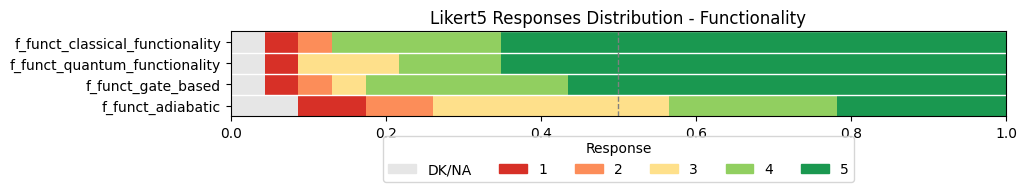

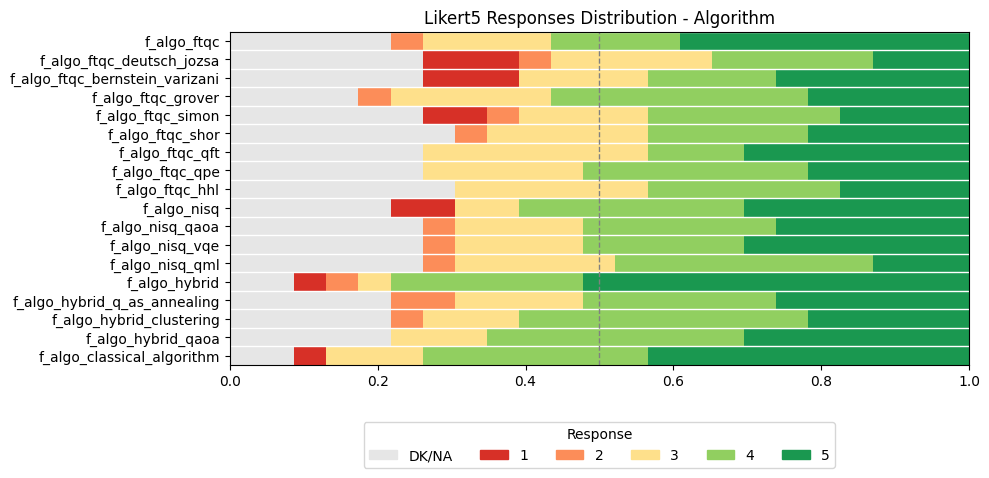

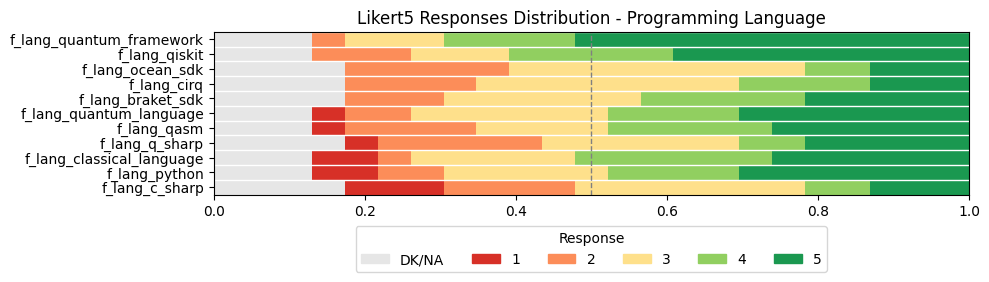

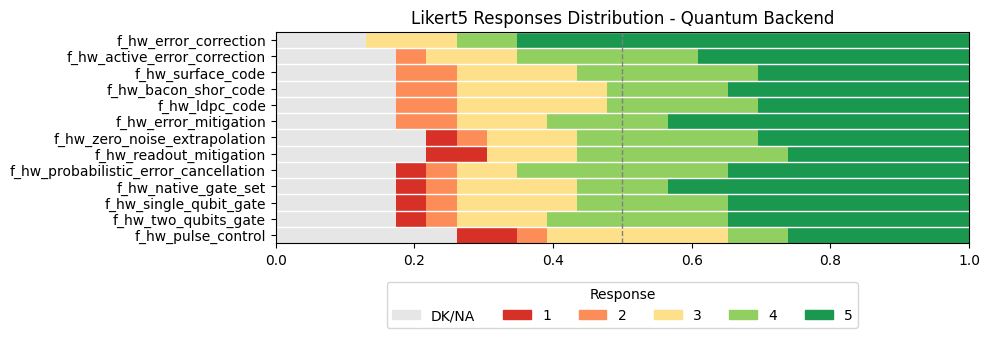

/tmp/ipython-input-3489345853.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


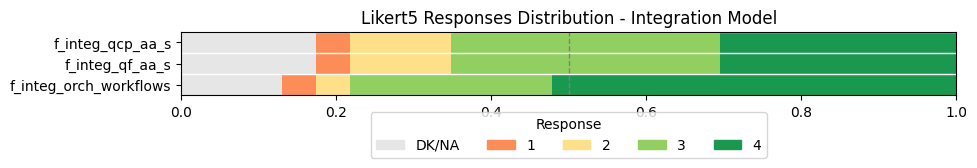

In [11]:
# Likert5 textual labels for legend
LIKERT_5_LABELS = ["DK/NA", "1", "2", "3", "4", "5"]

# Likert5 colors: DK/NA gray, 1 red → 5 green
LIKERT_5_COLORS = {
    0: "#e6e6e6",  # DK/NA gray
    1: "#d73027",  # red
    2: "#fc8d59",  # orange
    3: "#fee08b",  # amber
    4: "#91cf60",  # lime green
    5: "#1a9850",  # green
}

GEN_TITLE_MAP = {
    "gen_funct": "Functionality",
    "gen_algo": "Algorithm",
    "gen_lang": "Programming Language",
    "gen_hw": "Quantum Backend",
    "gen_integ": "Integration Model"
}

def plot_likert5_group_fixed_height(df, group_name, columns, bar_height_cm=0.6):
    """
    Plot 100% stacked horizontal bars for Likert5 variables,
    with fixed bar height (in cm) for all plots, no vertical gaps,
    and fully stacked.

    Parameters
    ----------
    df : pandas.DataFrame
        Processed DataFrame with numeric Likert5 columns
    group_name : str
        Name of the group
    columns : list
        List of Likert5 columns
    bar_height_cm : float
        Desired bar thickness in centimeters
    """
    if not columns:
        return

    df_group = df[columns]

    # Compute relative frequencies (percentages)
    df_percent = df_group.apply(lambda x: x.value_counts(normalize=True).sort_index()).fillna(0)
    df_percent = df_percent.T.iloc[::-1]  # reverse to have first variable at top

    n_vars = len(columns)

    # Convert bar height in cm to figure units
    dpi = 100  # figure dpi
    bar_height_inch = bar_height_cm / 2.54  # cm to inches
    fig_height = n_vars * bar_height_inch  # total figure height
    fig, ax = plt.subplots(figsize=(10, fig_height), dpi=dpi)

    # Plot stacked bars manually
    bottoms = np.zeros(n_vars)
    for val in sorted(df_percent.columns):
        ax.barh(
            y=np.arange(n_vars),
            width=df_percent[val],
            left=bottoms,
            color=LIKERT_5_COLORS.get(val, "#cccccc"),
            height=1.0
        )
        bottoms += df_percent[val].values

    # Add horizontal separator lines
    for y in range(n_vars):
        ax.hlines(y + 0.5, xmin=0, xmax=1, color='white', linestyle='-', linewidth=1)

    # Set limits and labels
    ax.set_ylim(-0.5, n_vars - 0.5)
    ax.set_xlim(0, 1)
    ax.set_yticks(np.arange(0, n_vars, 1))
    ax.set_yticklabels(df_percent.index)
    # ax.invert_yaxis()  # first variable at top

    # ax.set_xlabel("Proportion")
    # ax.set_ylabel("Variables")

    # Map raw group_name to natural-language title if available
    plot_title = GEN_TITLE_MAP.get(group_name, group_name)
    ax.set_title(f"Likert5 Responses Distribution - {plot_title}")

    # Vertical reference line at 50%
    ax.axvline(0.5, color="gray", linestyle="--", linewidth=1)

    # Legend below plot, horizontal
    handles = [plt.Rectangle((0,0),1,1,color=LIKERT_5_COLORS[v]) for v in sorted(df_percent.columns)]
    ax.legend(handles, LIKERT_5_LABELS, title="Response", loc='upper center',
              bbox_to_anchor=(0.5, -0.15), ncol=len(LIKERT_5_LABELS))

    plt.tight_layout()
    plt.show()


for group_name, cols in groups.items():
    plot_likert5_group_fixed_height(df, group_name, cols, bar_height_cm=0.7)


## features or intra-constraints without possitive valoration

**Statistical screening rationale (one-sided binomial test)**

**Goal.** For each Likert-5 item we quantify whether the item is *positively valued by users*. We define a response as *positive* if it is **4 or 5** on a 1–5 Likert scale. Let \(p\) be the true proportion of positive responses.

**Statistic.** We compute the empirical **positive rate**:
\[
\hat{p} = \frac{\#\{ \text{responses } \ge 4 \}}{\#\{\text{valid responses}\}}.
\]

**Hypothesis test (one-sided).**
- Null hypothesis \(H_0\): \(p = 0.50\) (the positive rate equals 50%).
- Alternative \(H_1\): \(p < 0.50\) (the positive rate is **below** 50%).

We run a **one-sided binomial test** with \(k\) = number of positive responses (4–5) and \(n\) = number of valid responses. The test returns a **p-value**:
- Small p-values (e.g., \(p < 0.05\)) provide evidence that the positive rate is **statistically below** 50%.

**Decision rule reported.**
- `valid_for_users = True` if \($\hat{p} \ge 0.50$).
- `valid_for_users = False` if \($\hat{p} < 0.50\$).
- We also report `significant_below_50` to indicate whether the test found \(\hat{p}\) **significantly** below 50% at \(\alpha=0.05\).

**Interpretation.**
- Items with `valid_for_users = False` are *not positively valued* according to the 50% criterion.
- If, in addition, `significant_below_50 = True`, the shortfall is statistically supported (one-sided binomial test).

**Notes.**
- Missing values and values outside {1,2,3,4,5} are ignored.
- You may adjust the threshold (e.g., 0.60) via `positive_threshold`, and the test level via `alpha`.
- If many items are tested, consider multiple-comparison corrections for formal inference in a confirmatory analysis.

In [12]:
# --- Screening of "positive for users" within pre-defined groups (from DATA_DICTIONARY) ---
# All code and comments in English.

import numpy as np
import pandas as pd
from scipy.stats import binomtest
from IPython.display import display, Markdown

def _likert5_positive_rate(series: pd.Series):
    """
    Compute counts and rate for Likert-5 where positive is {4,5}.
    Ignores NaN and values outside {1,2,3,4,5}.
    Returns: n_total, n_pos, pos_rate (float in [0,1]).
    """
    s = pd.to_numeric(series, errors="coerce").dropna()
    s = s[s.isin([1,2,3,4,5])]
    n = len(s)
    if n == 0:
        return 0, 0, np.nan
    n_pos = (s >= 4).sum()
    return n, n_pos, n_pos / n


def screen_valid_for_users_by_groups(df: pd.DataFrame,
                                     groups: "OrderedDict[str, list[str]]",
                                     alpha: float = 0.05,
                                     positive_threshold: float = 0.50,
                                     export_csv: bool = False):
    """
    For each group (as already discovered from DATA_DICTIONARY), compute:
      - positive_rate_4_5     (statistic)
      - one-sided binomial test p-value for H0: p = positive_threshold vs H1: p < threshold
      - decision valid_for_users: positive_rate_4_5 >= positive_threshold
      - significant_below_50: p-value < alpha (evidence of being below the threshold)

    Prints a table per group and returns a combined DataFrame with a 'group' column.
    """
    combined_rows = []

    # Iterate groups in the provided order (OrderedDict preserves your order)
    for gname, cols in groups.items():
        rows = []
        for col in cols:
            # Defensive: skip columns not present in df
            if col not in df.columns:
                rows.append({
                    "group": gname,
                    "variable": col,
                    "n": 0,
                    "positive_rate_4_5": np.nan,
                    f"p_value_pos_lt_{int(positive_threshold*100)}%": np.nan,
                    "valid_for_users": np.nan,
                    "significant_below_50": np.nan,
                    "note": "column not in df"
                })
                continue

            n, n_pos, pos_rate = _likert5_positive_rate(df[col])

            # Binomial one-sided test (only if we have data)
            if n > 0 and not np.isnan(pos_rate):
                pval = binomtest(k=n_pos, n=n, p=positive_threshold, alternative="less").pvalue
            else:
                pval = np.nan

            valid_for_users = (pos_rate >= positive_threshold) if not np.isnan(pos_rate) else np.nan
            significant_below = (pval < alpha) if not np.isnan(pval) else np.nan

            rows.append({
                "group": gname,
                "variable": col,
                "n": n,
                "positive_rate_4_5": pos_rate,
                f"p_value_pos_lt_{int(positive_threshold*100)}%": pval,
                "valid_for_users": valid_for_users,
                "significant_below_50": significant_below
            })

        group_df = pd.DataFrame(rows)

        # Pretty display (percentage as 0–100 with one decimal)
        to_show = group_df.copy()
        to_show["positive_rate_4_5"] = (to_show["positive_rate_4_5"] * 100).round(1)

        display(Markdown(f"### Group: `{gname}`"))
        display(
            to_show[[
                "variable",
                "n",
                "positive_rate_4_5",
                f"p_value_pos_lt_{int(positive_threshold*100)}%",
                "valid_for_users",
                "significant_below_50"
            ]].reset_index(drop=True)
        )

        if export_csv:
            safe_gname = "".join(ch if ch.isalnum() or ch in "_-" else "_" for ch in gname)
            to_show.to_csv(f"valid_for_users_screen_{safe_gname}.csv", index=False)

        combined_rows.append(group_df)

    # Return combined tidy DataFrame
    if combined_rows:
        combined = pd.concat(combined_rows, ignore_index=True)
        combined_display = combined.copy()
        combined_display["positive_rate_4_5"] = (combined_display["positive_rate_4_5"] * 100).round(1)
        return combined, combined_display
    else:
        return pd.DataFrame(), pd.DataFrame()


# ---------------------------
# USAGE (runs immediately):
# ---------------------------
# Assumes `df` and `groups` exist per your snippet above.
combined_raw, combined_pretty = screen_valid_for_users_by_groups(
    df=df,
    groups=groups,
    alpha=0.05,
    positive_threshold=0.50,
    export_csv=False  # set True to save per-group CSVs
)

# Optionally inspect or save the combined results:
# display(combined_pretty.sort_values(["group", "positive_rate_4_5"]))
# combined_pretty.to_csv("valid_for_users_screen_ALL_GROUPS.csv", index=False)


### Group: `gen_funct`

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_funct_classical_functionality,22,90.9,0.999995,True,False
1,f_funct_quantum_functionality,22,81.8,0.999572,True,False
2,f_funct_gate_based,22,86.4,0.999939,True,False
3,f_funct_adiabatic,21,47.6,0.500000,False,False


### Group: `gen_algo`

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_algo_ftqc,18,72.2,0.984558,True,False
1,f_algo_ftqc_deutsch_jozsa,17,47.1,0.500000,False,False
2,f_algo_ftqc_bernstein_varizani,17,58.8,0.833847,True,False
3,f_algo_ftqc_grover,19,68.4,0.968216,True,False
4,f_algo_ftqc_simon,17,58.8,0.833847,True,False
5,f_algo_ftqc_shor,16,62.5,0.894943,True,False
6,f_algo_ftqc_qft,17,58.8,0.833847,True,False
7,f_algo_ftqc_qpe,17,70.6,0.975479,True,False
8,f_algo_ftqc_hhl,16,62.5,0.894943,True,False
9,f_algo_nisq,18,77.8,0.996231,True,False


### Group: `gen_lang`

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_lang_quantum_framework,20,80.0,0.998712,True,False
1,f_lang_qiskit,20,70.0,0.979305,True,False
2,f_lang_ocean_sdk,19,26.3,0.031784,False,True
3,f_lang_cirq,19,36.8,0.179642,False,False
4,f_lang_braket_sdk,19,52.6,0.676197,True,False
5,f_lang_quantum_language,20,55.0,0.748278,True,False
6,f_lang_qasm,20,55.0,0.748278,True,False
7,f_lang_q_sharp,19,36.8,0.179642,False,False
8,f_lang_classical_language,20,60.0,0.868412,True,False
9,f_lang_python,20,55.0,0.748278,True,False


### Group: `gen_hw`

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_hw_error_correction,20,85.0,0.999799,True,False
1,f_hw_active_error_correction,19,78.9,0.997787,True,False
2,f_hw_surface_code,19,68.4,0.968216,True,False
3,f_hw_bacon_shor_code,19,63.2,0.916466,True,False
4,f_hw_ldpc_code,19,63.2,0.916466,True,False
5,f_hw_error_mitigation,19,73.7,0.990395,True,False
6,f_hw_zero_noise_extrapolation,18,72.2,0.984558,True,False
7,f_hw_readout_mitigation,18,72.2,0.984558,True,False
8,f_hw_probabilistic_error_cancellation,19,78.9,0.997787,True,False
9,f_hw_native_gate_set,19,68.4,0.968216,True,False


### Group: `gen_integ`

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_integ_qcp_aa_s,19,78.9,0.997787,True,False
1,f_integ_qf_aa_s,19,78.9,0.997787,True,False
2,f_integ_orch_workflows,20,90.0,0.999980,True,False


## features or intra-constraints without possitive valoration (without begginers)

In [13]:
# --- Screening "valid for users" restricted by experience level (column: exp_q) ---
# All code and comments in English.

import numpy as np
import pandas as pd
from scipy.stats import binomtest
from IPython.display import display, Markdown

# We reuse _likert5_positive_rate from your previous cell.
# If it is not in scope for some reason, uncomment this definition:
# def _likert5_positive_rate(series: pd.Series):
#     s = pd.to_numeric(series, errors="coerce").dropna()
#     s = s[s.isin([1,2,3,4,5])]
#     n = len(s)
#     if n == 0:
#         return 0, 0, np.nan
#     n_pos = (s >= 4).sum()
#     return n, n_pos, n_pos / n

def screen_valid_for_users_by_groups_with_experience(df: pd.DataFrame,
                                                     groups: "OrderedDict[str, list[str]]",
                                                     exp_col: str = "exp_q",
                                                     include_levels=None,
                                                     alpha: float = 0.05,
                                                     positive_threshold: float = 0.50,
                                                     export_csv: bool = False,
                                                     title_suffix: str = ""):
    """
    Run the same screening as 'screen_valid_for_users_by_groups' but on a filtered subset
    of respondents according to the experience column `exp_col`.

    Parameters
    ----------
    df : pd.DataFrame
        Full survey dataframe.
    groups : OrderedDict[str, list[str]]
        Groups and their Likert-5 variables (features only).
    exp_col : str
        Column holding respondent experience text labels (e.g., "exp_q").
    include_levels : list[str] or None
        Which textual levels to keep. If None, defaults to excluding only "Beginner (0-1 years)"
        and keeping Intermediate, Advanced, and Expert.
        Examples:
          - None (default): keep non-beginners only.
          - ["Expert (7+ years)"]: keep experts only.
          - ["Intermediate (1-3 years)", "Advanced (3-5 years)", "Expert (7+ years)"]: explicit non-beginners.
    alpha : float
        Significance level for the one-sided binomial test.
    positive_threshold : float
        Threshold for the positive rate (>= 4 on Likert-5) to declare valid_for_users.
    export_csv : bool
        If True, saves per-group CSVs of the pretty table.
    title_suffix : str
        Optional string appended to the per-group title to indicate the filter used.

    Returns
    -------
    combined_raw : pd.DataFrame
        Tidy numeric results across all groups (subset-filtered).
    combined_display : pd.DataFrame
        Human-friendly copy with percentages in [0,100].
    """
    # Define canonical labels (as per your provided examples)
    NON_BEGINNER_DEFAULT = [
        "Intermediate (1-3 years)",
        "Advanced (3-5 years)",
        "Expert (7+ years)"
    ]

    if include_levels is None:
        include_levels = NON_BEGINNER_DEFAULT

    # Filter dataframe by experience
    if exp_col not in df.columns:
        raise KeyError(f"Column '{exp_col}' not found in df.")

    df_filt = df[df[exp_col].isin(include_levels)].copy()

    # Report the filter being used
    display(Markdown(
        f"**Experience filter applied** on `{exp_col}`: {', '.join(include_levels)}  "
        f"(n = {len(df_filt)})"
    ))

    combined_rows = []

    for gname, cols in groups.items():
        rows = []
        for col in cols:
            if col not in df_filt.columns:
                rows.append({
                    "group": gname,
                    "variable": col,
                    "n": 0,
                    "positive_rate_4_5": np.nan,
                    f"p_value_pos_lt_{int(positive_threshold*100)}%": np.nan,
                    "valid_for_users": np.nan,
                    "significant_below_50": np.nan,
                    "note": "column not in filtered df"
                })
                continue

            n, n_pos, pos_rate = _likert5_positive_rate(df_filt[col])

            if n > 0 and not np.isnan(pos_rate):
                pval = binomtest(k=n_pos, n=n, p=positive_threshold, alternative="less").pvalue
            else:
                pval = np.nan

            valid_for_users = (pos_rate >= positive_threshold) if not np.isnan(pos_rate) else np.nan
            significant_below = (pval < alpha) if not np.isnan(pval) else np.nan

            rows.append({
                "group": gname,
                "variable": col,
                "n": n,
                "positive_rate_4_5": pos_rate,
                f"p_value_pos_lt_{int(positive_threshold*100)}%": pval,
                "valid_for_users": valid_for_users,
                "significant_below_50": significant_below
            })

        group_df = pd.DataFrame(rows)

        # Pretty display (percentage as 0–100 with one decimal)
        to_show = group_df.copy()
        to_show["positive_rate_4_5"] = (to_show["positive_rate_4_5"] * 100).round(1)

        subtitle = title_suffix.strip()
        hdr = f"### Group: `{gname}`"
        if subtitle:
            hdr += f" — {subtitle}"

        display(Markdown(hdr))
        display(
            to_show[[
                "variable",
                "n",
                "positive_rate_4_5",
                f"p_value_pos_lt_{int(positive_threshold*100)}%",
                "valid_for_users",
                "significant_below_50"
            ]].reset_index(drop=True)
        )

        if export_csv:
            def _safe(s): return "".join(ch if ch.isalnum() or ch in "_-" else "_" for ch in str(s))
            safe_gname = _safe(gname)
            safe_suffix = _safe(subtitle) if subtitle else "filtered"
            to_show.to_csv(f"valid_for_users_screen_{safe_gname}_{safe_suffix}.csv", index=False)

        combined_rows.append(group_df)

    if combined_rows:
        combined = pd.concat(combined_rows, ignore_index=True)
        combined_display = combined.copy()
        combined_display["positive_rate_4_5"] = (combined_display["positive_rate_4_5"] * 100).round(1)
        return combined, combined_display
    else:
        return pd.DataFrame(), pd.DataFrame()


# ---------------------------
# USAGE EXAMPLES
# ---------------------------

# A) Non-beginners only (default): Intermediate + Advanced + Expert
combined_raw_nb, combined_pretty_nb = screen_valid_for_users_by_groups_with_experience(
    df=df,
    groups=groups,
    exp_col="exp_q",
    include_levels=None,                   # None -> keeps Intermediate, Advanced, Expert
    alpha=0.05,
    positive_threshold=0.50,
    export_csv=False,
    title_suffix="non-beginners only"
)

# B) Experts only
combined_raw_expert, combined_pretty_expert = screen_valid_for_users_by_groups_with_experience(
    df=df,
    groups=groups,
    exp_col="exp_q",
    include_levels=["Expert (7+ years)"],  # keep only Experts
    alpha=0.05,
    positive_threshold=0.50,
    export_csv=False,
    title_suffix="experts only"
)

# C) Intermediate + Advanced (exclude both Beginners and Experts), if ever needed:
# combined_raw_ia, combined_pretty_ia = screen_valid_for_users_by_groups_with_experience(
#     df=df,
#     groups=groups,
#     exp_col="exp_q",
#     include_levels=["Intermediate (1-3 years)", "Advanced (3-5 years)"],
#     alpha=0.05,
#     positive_threshold=0.50,
#     export_csv=False,
#     title_suffix="intermediate & advanced"
# )

**Experience filter applied** on `exp_q`: Intermediate (1-3 years), Advanced (3-5 years), Expert (7+ years)  (n = 21)

### Group: `gen_funct` — non-beginners only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_funct_classical_functionality,20,95.0,0.999999,True,False
1,f_funct_quantum_functionality,20,85.0,0.999799,True,False
2,f_funct_gate_based,20,90.0,0.999980,True,False
3,f_funct_adiabatic,19,47.4,0.500000,False,False


### Group: `gen_algo` — non-beginners only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_algo_ftqc,18,72.2,0.984558,True,False
1,f_algo_ftqc_deutsch_jozsa,17,47.1,0.500000,False,False
2,f_algo_ftqc_bernstein_varizani,17,58.8,0.833847,True,False
3,f_algo_ftqc_grover,19,68.4,0.968216,True,False
4,f_algo_ftqc_simon,17,58.8,0.833847,True,False
5,f_algo_ftqc_shor,16,62.5,0.894943,True,False
6,f_algo_ftqc_qft,17,58.8,0.833847,True,False
7,f_algo_ftqc_qpe,17,70.6,0.975479,True,False
8,f_algo_ftqc_hhl,16,62.5,0.894943,True,False
9,f_algo_nisq,18,77.8,0.996231,True,False


### Group: `gen_lang` — non-beginners only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_lang_quantum_framework,20,80.0,0.998712,True,False
1,f_lang_qiskit,20,70.0,0.979305,True,False
2,f_lang_ocean_sdk,19,26.3,0.031784,False,True
3,f_lang_cirq,19,36.8,0.179642,False,False
4,f_lang_braket_sdk,19,52.6,0.676197,True,False
5,f_lang_quantum_language,20,55.0,0.748278,True,False
6,f_lang_qasm,20,55.0,0.748278,True,False
7,f_lang_q_sharp,19,36.8,0.179642,False,False
8,f_lang_classical_language,20,60.0,0.868412,True,False
9,f_lang_python,20,55.0,0.748278,True,False


### Group: `gen_hw` — non-beginners only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_hw_error_correction,20,85.0,0.999799,True,False
1,f_hw_active_error_correction,19,78.9,0.997787,True,False
2,f_hw_surface_code,19,68.4,0.968216,True,False
3,f_hw_bacon_shor_code,19,63.2,0.916466,True,False
4,f_hw_ldpc_code,19,63.2,0.916466,True,False
5,f_hw_error_mitigation,19,73.7,0.990395,True,False
6,f_hw_zero_noise_extrapolation,18,72.2,0.984558,True,False
7,f_hw_readout_mitigation,18,72.2,0.984558,True,False
8,f_hw_probabilistic_error_cancellation,19,78.9,0.997787,True,False
9,f_hw_native_gate_set,19,68.4,0.968216,True,False


### Group: `gen_integ` — non-beginners only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_integ_qcp_aa_s,19,78.9,0.997787,True,False
1,f_integ_qf_aa_s,19,78.9,0.997787,True,False
2,f_integ_orch_workflows,20,90.0,0.999980,True,False


**Experience filter applied** on `exp_q`: Expert (7+ years)  (n = 1)

### Group: `gen_funct` — experts only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_funct_classical_functionality,1,100.0,1.0,True,False
1,f_funct_quantum_functionality,1,100.0,1.0,True,False
2,f_funct_gate_based,1,100.0,1.0,True,False
3,f_funct_adiabatic,1,100.0,1.0,True,False


### Group: `gen_algo` — experts only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_algo_ftqc,1,100.0,1.0,True,False
1,f_algo_ftqc_deutsch_jozsa,1,100.0,1.0,True,False
2,f_algo_ftqc_bernstein_varizani,1,100.0,1.0,True,False
3,f_algo_ftqc_grover,1,100.0,1.0,True,False
4,f_algo_ftqc_simon,1,100.0,1.0,True,False
5,f_algo_ftqc_shor,1,100.0,1.0,True,False
6,f_algo_ftqc_qft,1,100.0,1.0,True,False
7,f_algo_ftqc_qpe,1,100.0,1.0,True,False
8,f_algo_ftqc_hhl,1,100.0,1.0,True,False
9,f_algo_nisq,1,100.0,1.0,True,False


### Group: `gen_lang` — experts only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_lang_quantum_framework,1,100.0,1.0,True,False
1,f_lang_qiskit,1,100.0,1.0,True,False
2,f_lang_ocean_sdk,1,100.0,1.0,True,False
3,f_lang_cirq,1,100.0,1.0,True,False
4,f_lang_braket_sdk,1,100.0,1.0,True,False
5,f_lang_quantum_language,1,0.0,0.5,False,False
6,f_lang_qasm,1,0.0,0.5,False,False
7,f_lang_q_sharp,1,0.0,0.5,False,False
8,f_lang_classical_language,1,0.0,0.5,False,False
9,f_lang_python,1,0.0,0.5,False,False


### Group: `gen_hw` — experts only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_hw_error_correction,1,0.0,0.5,False,False
1,f_hw_active_error_correction,1,0.0,0.5,False,False
2,f_hw_surface_code,1,0.0,0.5,False,False
3,f_hw_bacon_shor_code,1,0.0,0.5,False,False
4,f_hw_ldpc_code,1,0.0,0.5,False,False
5,f_hw_error_mitigation,1,0.0,0.5,False,False
6,f_hw_zero_noise_extrapolation,1,0.0,0.5,False,False
7,f_hw_readout_mitigation,1,0.0,0.5,False,False
8,f_hw_probabilistic_error_cancellation,1,0.0,0.5,False,False
9,f_hw_native_gate_set,1,0.0,0.5,False,False


### Group: `gen_integ` — experts only

,variable,n,positive_rate_4_5,p_value_pos_lt_50%,valid_for_users,significant_below_50
0,f_integ_qcp_aa_s,1,100.0,1.0,True,False
1,f_integ_qf_aa_s,1,100.0,1.0,True,False
2,f_integ_orch_workflows,1,100.0,1.0,True,False


In [14]:
#@title Frequency tables for categorical variables (edit COLS accordingly)
CATEGORICAL_COLS = ["phase", "role", "exp_q", "exp_spl", "qc_areas", "country"]  # e.g., ["role", "country", "framework_primary"]
freq_tables = {}
for col in CATEGORICAL_COLS:
    vc = df[col].value_counts(dropna=False)
    freq_tables[col] = vc
    print("\n=== {} ===".format(col))
    display(vc)


=== phase ===


,count
phase,
"Analysis, Design",10
"Analysis, Design, Coding, Testing, Execution",3
Analysis,2
"Analysis, Design, Coding, Testing",2
"Design, Testing",2
"Analysis, Design, Coding",1
"Design, Coding",1
"Design, Execution",1
"Design, Testing, Execution",1



=== role ===


,count
role,
Academia,19
"Academia, Industry",2
Industry,2



=== exp_q ===


,count
exp_q,
Intermediate (1-3 years),11
Advanced (3-5 years),9
Beginner (0-1 years),2
Expert (7+ years),1



=== exp_spl ===


,count
exp_spl,
Beginner (0-1 years),12
Intermediate (1-3 years),5
Advanced (3-5 years),4
Expert (7+ years),2



=== qc_areas ===


,count
qc_areas,
"Quantum Software Engineering, Hybrid Classical-Quantum Software Development",4
"Quantum Software Engineering, Quantum Algorithms, Quantum Software Testing",2
Quantum Software Engineering,2
"Quantum Software Engineering, Hybrid Classical-Quantum Software Development, Quantum Software Testing, Quantum Machine Learning",2
"Hybrid Classical-Quantum Software Development, Quantum Optimization, Quantum Machine Learning",1
Quantum Machine Learning,1
Quantum Error Correction,1
"Quantum Algorithms, Quantum Error Correction, Qunatum Networking",1
"Quantum Algorithms, Quantum Machine Learning",1



=== country ===


,count
country,
NaN,9
Spain,4
Japan,2
Chile,2
Germany,1
Italy,1
New Zealand,1
Luxembourg,1
Portugal,1


## 6. Reliability analysis (Cronbach's alpha)

**Purpose.** Cronbach’s alpha (α) estimates the **internal consistency** (reliability) of a set of items intended to measure the same construct. Higher α suggests that items share common variance and move together as a scale.

**Computation.** $For (k) items (X_1,dots,X_k) scored numerically (e.g., Likert), and after listwise deletion of missing values, we compute:
[
\alpha = \frac{k}{k-1}\Bigg(1 - \frac{\sum_{i=1}^{k} s_i^2}{s_T^2}\Bigg)], where (s_i^2) is the sample variance of item (i), and (s_T^2) is the variance of the **row-wise sum** (T = \sum_i X_i).$

**Interpretation (rules of thumb, not hard cutoffs).**
- **≥ 0.90**: Excellent  
- **0.80–0.89**: Good  
- **0.70–0.79**: Acceptable  
- **0.60–0.69**: Questionable  
- **0.50–0.59**: Poor  
- **< 0.50**: Unacceptable

**Reading the results table.**
- **construct**: name of the latent variable you defined.  
- **k_items**: number of items in the construct (≥ 2 required).  
- **n_used**: number of responses used **after** listwise NA removal.  
- **alpha**: Cronbach’s α (rounded to three decimals in the display).  
- **interpretation**: qualitative label per the thresholds above.  
- **notes**: quick guidance (e.g., possible item redundancy if α>0.95; consider item review if α<0.70).

**Good practice and caveats.**
- α assumes **tau-equivalence** and is sensitive to the **number of items** and **item variance** (longer scales often inflate α).  
- A very high α (>0.95) can indicate **redundant items**.  
- A low α may reflect **heterogeneous content**, **few items**, or **restricted variance** (e.g., ceiling effects).  
- Always complement α with **item diagnostics** (e.g., item–total correlations, α if item deleted), **factor analysis**, and external **validity** checks.

**Tip for Colab rendering.** Use a Markdown cell (not a code cell) to render LaTeX like \(\alpha\) and \(\hat{p}\). If generating Markdown from Python, wrap strings as raw literals (e.g., `r"""..."""`) to preserve backslashes.


In [15]:
# --- Build CONSTRUCTS from previously computed `groups` and (optionally) compute Cronbach’s alpha ---
# All code and comments in English.

import pandas as pd
from IPython.display import display, Markdown

def _pretty_construct_name(group_key: str) -> str:
    """
    Turn a group key like 'gen_process' into a readable construct name: 'Process'.
    Keeps a short descriptor; you can adapt this to your naming conventions.
    """
    key = str(group_key)
    if key.startswith("gen_"):
        key = key[4:]
    return key.replace("_", " ").strip().title()

# 1) Build CONSTRUCTS directly from `groups` (features only, since c_* were already ignored)
CONSTRUCTS = {}
for gname, cols in groups.items():
    # gname is the 'gen_*' column (group header). Use a pretty label for readability.
    pretty = _pretty_construct_name(gname)
    # Only keep non-empty lists
    if cols:
        CONSTRUCTS[pretty] = list(cols)

# 2) Show a compact preview of the constructs (name -> #items)
if not CONSTRUCTS:
    display(Markdown("> **No constructs built from `groups`.** Check that `groups` is non-empty."))
else:
    display(Markdown("### Constructs built from `groups`"))
    preview_rows = [{"construct": k, "k_items": len(v)} for k, v in CONSTRUCTS.items()]
    display(pd.DataFrame(preview_rows).sort_values("construct").reset_index(drop=True))

# 3) If `cronbach_alpha` is defined in the notebook, compute interpreted α per construct
if "cronbach_alpha" in globals():
    def _interpret_alpha(a: float) -> str:
        if pd.isna(a): return "NA"
        if a >= 0.90: return "Excellent"
        if a >= 0.80: return "Good"
        if a >= 0.70: return "Acceptable"
        if a >= 0.60: return "Questionable"
        if a >= 0.50: return "Poor"
        return "Unacceptable"

    records = []
    for name, cols in CONSTRUCTS.items():
        # Coerce to numeric and perform listwise deletion within the construct
        sub = df[cols].apply(pd.to_numeric, errors="coerce")
        sub_clean = sub.dropna(axis=0, how="any")
        k_items = len(cols)
        n_used = len(sub_clean)
        a = cronbach_alpha(sub_clean) if (k_items > 1 and n_used > 1) else float("nan")
        note = ""
        if pd.isna(a):
            note = "Insufficient items/variance or too many missing values."
        elif a < 0.70:
            note = "Consider reviewing items; check item–total correlations."
        elif a > 0.95:
            note = "Possible redundancy among items."

        records.append({
            "construct": name,
            "k_items": k_items,
            "n_used": n_used,
            "alpha": a,
            "interpretation": _interpret_alpha(a),
            "notes": note
        })

    res = pd.DataFrame.from_records(records)
    if not res.empty:
        res_disp = res.copy()
        res_disp["alpha"] = res_disp["alpha"].round(3)
        display(Markdown("### Cronbach’s alpha by construct (interpreted)"))
        display(res_disp[["construct", "k_items", "n_used", "alpha", "interpretation", "notes"]]
                .sort_values(["alpha"], ascending=[False], na_position="last")
                .reset_index(drop=True))
else:
    display(Markdown("> `cronbach_alpha` is not defined in the current scope. "
                     "Define it first to compute reliability for these constructs."))


### Constructs built from `groups`

,construct,k_items
0,Algo,18
1,Funct,4
2,Hw,13
3,Integ,3
4,Lang,11


### Cronbach’s alpha by construct (interpreted)

,construct,k_items,n_used,alpha,interpretation,notes
0,Algo,18,23,0.979,Excellent,Possible redundancy among items.
1,Lang,11,23,0.970,Excellent,Possible redundancy among items.
2,Hw,13,23,0.965,Excellent,Possible redundancy among items.
3,Integ,3,23,0.965,Excellent,Possible redundancy among items.
4,Funct,4,23,0.892,Good,


###McDonald’s Omega (ω total)

In [16]:
# === McDonald's Omega (ω) per construct with real per-branch n and missing-data handling ===
# Works in Google Colab. Assumes `df` (responses DataFrame) and `CONSTRUCTS` (dict: name -> list of columns) exist.

!pip -q install factor-analyzer

import numpy as np
import pandas as pd
from itertools import combinations
from IPython.display import display, Markdown

# Optional: MINRES (requires complete cases per construct)
from factor_analyzer import FactorAnalyzer

# ----------------------------
# Configuration
# ----------------------------
# If True, always use PCA-based omega on Spearman (pairwise) -> leverages all available data (recommended with small n).
# If False, try MINRES on rank-transformed data (complete cases); on failure, fallback to PCA.
FORCE_PCA_ONLY = True

# ----------------------------
# Utilities
# ----------------------------
def _interpret_omega(w: float) -> str:
    if pd.isna(w): return "NA"
    if w >= 0.90: return "Excellent"
    if w >= 0.80: return "Good"
    if w >= 0.70: return "Acceptable"
    if w >= 0.60: return "Questionable"
    return "Poor/Unacceptable"

def _pairwise_min_n(df_sub: pd.DataFrame) -> int:
    """Minimum number of non-missing pairs across all item pairs (support for pairwise Spearman)."""
    cols = df_sub.columns.tolist()
    if len(cols) == 0:
        return 0
    if len(cols) == 1:
        return int(df_sub[cols[0]].notna().sum())
    mins = []
    for a, b in combinations(cols, 2):
        mins.append(int(df_sub[[a, b]].dropna(how="any").shape[0]))
    return min(mins) if mins else 0

def _omega_from_loadings_uniqueness(loadings: np.ndarray, uniqueness: np.ndarray) -> float:
    loadings = np.asarray(loadings).flatten()
    uniqueness = np.asarray(uniqueness).flatten()
    if np.any(~np.isfinite(loadings)) or np.any(~np.isfinite(uniqueness)):
        return np.nan
    uniqueness = np.clip(uniqueness, 0.0, None)
    num = (np.sum(loadings))**2
    den = num + np.sum(uniqueness)
    return float(num / den) if den > 0 else np.nan

def _omega_pca_fallback(df_sub: pd.DataFrame) -> float:
    """
    PCA-based omega on Spearman correlation (pairwise).
    For 1-factor approximation: λ_i = sqrt(eig1) * v1_i, ψ_i = 1 - λ_i^2 (since R is a correlation matrix).
    """
    # Pairwise Spearman correlation
    R = df_sub.corr(method="spearman").to_numpy()
    # Symmetrize, clip, set diag to 1
    R = (R + R.T) / 2.0
    np.fill_diagonal(R, 1.0)
    R = np.clip(R, -1.0, 1.0)

    # Eigen-decomposition
    vals, vecs = np.linalg.eigh(R)
    idx = np.argsort(vals)[::-1]
    eig1 = float(vals[idx[0]])
    v1 = vecs[:, idx[0]]
    # First component loadings
    loadings = np.sqrt(max(eig1, 0.0)) * v1
    communality = np.clip(loadings**2, 0.0, 1.0)
    uniqueness = 1.0 - communality
    return _omega_from_loadings_uniqueness(loadings, uniqueness)

def _omega_minres_on_ranks(df_complete: pd.DataFrame) -> float:
    """
    Fit 1-factor MINRES on rank-transformed data (Pearson on ranks ≈ Spearman).
    Requires complete cases for the selected items.
    """
    ranked = df_complete.rank(method="average")
    fa = FactorAnalyzer(n_factors=1, rotation=None, method="minres")
    fa.fit(ranked.values)
    loadings = fa.loadings_.flatten()
    uniqueness = fa.get_uniquenesses().flatten()
    return _omega_from_loadings_uniqueness(loadings, uniqueness)

def _compute_omega_for_construct(df: pd.DataFrame, cols: list, force_pca: bool = True):
    """
    Returns (omega, n_used, note).
    - If force_pca: uses PCA on Spearman (pairwise), n_used = min pairwise n among item pairs.
    - Else: tries MINRES on complete cases; if fails, fallback to PCA; n_used reported accordingly.
    """
    sub = df[cols].apply(pd.to_numeric, errors="coerce")
    k_items = len(cols)

    if k_items < 2:
        return np.nan, 0, "Insufficient items (<2)."

    # Availability
    n_total = len(sub)
    n_complete = len(sub.dropna(how="any"))
    n_min_pair = _pairwise_min_n(sub)

    if force_pca:
        if n_min_pair < 4:
            return np.nan, n_min_pair, "Too few responses (pairwise) for ω."
        try:
            w = _omega_pca_fallback(sub)
            note = "PCA (pairwise Spearman)."
            if np.isfinite(w) and w > 0.95:
                note += " Possible redundancy among items."
            elif np.isfinite(w) and w < 0.70:
                note += " Low common variance; consider reviewing items."
            return w, n_min_pair, note
        except Exception as e:
            return np.nan, n_min_pair, f"Estimation failed (PCA): {e}"

    # MINRES route (complete cases), then fallback
    if n_complete >= 4:
        try:
            w = _omega_minres_on_ranks(sub.dropna(how="any"))
            note = "MINRES on ranks (complete cases)."
            if not np.isfinite(w):
                raise RuntimeError("MINRES returned non-finite ω.")
            if w > 0.95:
                note += " Possible redundancy among items."
            elif w < 0.70:
                note += " Low common variance; consider reviewing items."
            return w, n_complete, note
        except Exception as e:
            # Fallback to PCA (pairwise)
            try:
                w = _omega_pca_fallback(sub)
                note = f"PCA fallback (MINRES failed: {e})."
                if np.isfinite(w) and w > 0.95:
                    note += " Possible redundancy among items."
                elif np.isfinite(w) and w < 0.70:
                    note += " Low common variance; consider reviewing items."
                return w, n_min_pair, note
            except Exception as e2:
                return np.nan, n_min_pair, f"Estimation failed (both MINRES and PCA): {e}; fallback: {e2}"
    else:
        # Not enough complete cases; use PCA (pairwise)
        if n_min_pair < 4:
            return np.nan, n_min_pair, "Too few responses (pairwise) for ω."
        try:
            w = _omega_pca_fallback(sub)
            note = "PCA (pairwise Spearman) due to insufficient complete cases."
            if np.isfinite(w) and w > 0.95:
                note += " Possible redundancy among items."
            elif np.isfinite(w) and w < 0.70:
                note += " Low common variance; consider reviewing items."
            return w, n_min_pair, note
        except Exception as e:
            return np.nan, n_min_pair, f"Estimation failed (PCA): {e}"

# ----------------------------
# Run: availability + omega by construct
# ----------------------------
if "CONSTRUCTS" not in globals() or not isinstance(CONSTRUCTS, dict) or len(CONSTRUCTS) == 0:
    display(Markdown("> **No constructs available.** Please build `CONSTRUCTS` first."))
else:
    # Availability diagnostics
    rows_diag = []
    for name, cols in CONSTRUCTS.items():
        sub = df[cols].apply(pd.to_numeric, errors="coerce")
        rows_diag.append({
            "construct": name,
            "k_items": len(cols),
            "n_total_rows": len(sub),
            "n_complete_rows": len(sub.dropna(how='any')),
            "n_min_pairwise": _pairwise_min_n(sub),
        })
    diag_df = pd.DataFrame(rows_diag).sort_values("construct").reset_index(drop=True)
    display(Markdown("### Availability per construct"))
    display(diag_df)

    # Omega computation
    records = []
    for name, cols in CONSTRUCTS.items():
        w, n_used, note = _compute_omega_for_construct(df, cols, force_pca=FORCE_PCA_ONLY)
        records.append({
            "construct": name,
            "k_items": len(cols),
            "n_used": n_used,
            "omega_total": w,
            "interpretation": _interpret_omega(w),
            "notes": note
        })

    res = pd.DataFrame.from_records(records)
    if not res.empty:
        res_disp = res.copy()
        # Round omega for display
        if "omega_total" in res_disp:
            res_disp["omega_total"] = res_disp["omega_total"].round(3)
        display(Markdown("### McDonald’s Omega (ω total) by construct"))
        display(res_disp.sort_values(["omega_total"], ascending=[False], na_position="last").reset_index(drop=True))

    # Reminder for small n
    if not res.empty and (res["n_used"] < 30).any():
        display(Markdown(
            "> **Note:** Given the small effective n per construct, treat ω as exploratory and "
            "report the per-branch n used (pairwise/complete) alongside results."
        ))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 818.3 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Availability per construct

,construct,k_items,n_total_rows,n_complete_rows,n_min_pairwise
0,Algo,18,23,23,23
1,Funct,4,23,23,23
2,Hw,13,23,23,23
3,Integ,3,23,23,23
4,Lang,11,23,23,23


### McDonald’s Omega (ω total) by construct

,construct,k_items,n_used,omega_total,interpretation,notes
0,Algo,18,23,0.973,Excellent,PCA (pairwise Spearman). Possible redundancy a...
1,Integ,3,23,0.969,Excellent,PCA (pairwise Spearman). Possible redundancy a...
2,Lang,11,23,0.964,Excellent,PCA (pairwise Spearman). Possible redundancy a...
3,Hw,13,23,0.961,Excellent,PCA (pairwise Spearman). Possible redundancy a...
4,Funct,4,23,0.866,Good,PCA (pairwise Spearman).


> **Note:** Given the small effective n per construct, treat ω as exploratory and report the per-branch n used (pairwise/complete) alongside results.

## 7. Cross-tabs & basic significance tests

In [17]:

#@title Chi-square tests for association (categorical x categorical)
PAIRS_CATEG = []  # e.g., [("role", "framework_primary")]
for a, b in PAIRS_CATEG:
    ct = pd.crosstab(df[a], df[b])
    chi2, p, dof, exp = stats.chi2_contingency(ct.fillna(0))
    print("\n{} vs {}".format(a, b))
    display(ct)
    print("chi2={:.3f}, dof={}, p={:.4f}".format(chi2, dof, p))


In [18]:

#@title T-test / ANOVA for numeric outcomes (edit as needed)
# Example: Does perceived usefulness differ by role?
# OUTCOME = "fm_var_mgmt"
# GROUP = "role"
# dropna_rows = df[[OUTCOME, GROUP]].dropna()
# groups = [vals[OUTCOME].astype(float).values for _, vals in dropna_rows.groupby(GROUP)]
# if len(groups) > 1:
#     f, p = stats.f_oneway(*groups)
#     print("ANOVA: F={:.3f}, p={:.4f}".format(f, p))
# else:
#     print("Not enough groups for ANOVA")


## 8. Publication-ready tables & figures

In [19]:

#@title Example: Likert stacked bar (5-point)
# Provide a helper to transform Likert columns to percentages per label
LIKERT_ORDER = [1, 2, 3, 4, 5]  # after mapping to numeric
LIKERT_LABELS = ["Strongly disagree","Disagree","Neutral","Agree","Strongly agree"]

def likert_table(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    # expects numeric 1..5
    table = []
    for c in cols:
        counts = df[c].value_counts().reindex(LIKERT_ORDER, fill_value=0)
        perc = (counts / counts.sum() * 100).round(1)
        row = perc.rename(c)
        table.append(row)
    out = pd.DataFrame(table, columns=LIKERT_ORDER)
    out.columns = LIKERT_LABELS
    return out

# Example usage:
LIKERT_COLS = []  # e.g., ["fm_var_mgmt", "fm_algo_select", "fm_integration"]
if LIKERT_COLS:
    tbl = likert_table(df, LIKERT_COLS)
    display(tbl)
    tbl.to_csv(OUTPUT_DIR / "likert_table.csv")


In [20]:

#@title Plot: Likert stacked bars
def plot_likert_stacked(table: pd.DataFrame, title: str = "Perception of FM"):
    # table columns should be ordered as LIKERT_LABELS
    ax = table.plot(kind="bar", stacked=True, figsize=(10, 4))
    plt.title(title)
    plt.xlabel("Item")
    plt.ylabel("Percentage")
    plt.legend(title="Response", bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    out = OUTPUT_DIR / ("likert_stacked_" + title.replace(" ", "_").lower() + ".png")
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

# Example:
# if LIKERT_COLS:
#     tbl = likert_table(df, LIKERT_COLS)
#     plot_likert_stacked(tbl, title="Usefulness of the Feature Model")


## 9. Reproducibility

In [21]:

#@title Save session info and a minimal requirements file
import platform, subprocess

session = {
    "python": sys.version,
    "platform": platform.platform(),
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "matplotlib": plt.matplotlib.__version__,
    "scipy": stats.__version__ if hasattr(stats, '__version__') else None,
    "statsmodels": sm.__version__,
    "gspread": HAS_GSPREAD,
}
with open(OUTPUT_DIR / "session_info.json", "w") as f:
    json.dump(session, f, indent=2)
print(json.dumps(session, indent=2))

# Minimal requirements (edit as needed)
req = """
pandas
numpy
matplotlib
scipy
statsmodels
gspread
gspread-dataframe
"""
with open(OUTPUT_DIR / "requirements.txt", "w") as f:
    f.write(req.strip() + "\n")
print("Wrote:", OUTPUT_DIR / "requirements.txt")


{
  "python": "3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]",
  "platform": "Linux-6.6.105+-x86_64-with-glibc2.35",
  "pandas": "2.2.2",
  "numpy": "2.0.2",
  "matplotlib": "3.10.0",
  "scipy": null,
  "statsmodels": "0.14.5",
  "gspread": true
}
Wrote: /content/outputs/requirements.txt



## Appendix: Paper-oriented narrative (to fill in)

### A. Research Questions (RQs)
- RQ1: *To what extent does the proposed Feature Model cover variability in functionalities, algorithms, frameworks and integration models for hybrid Q–C systems?*
- RQ2: *What is the perceived usefulness and ease of use of the Feature Model among QSE experts?*
- RQ3: *Which factors (e.g., role, experience, domain) explain differences in adoption intent?*

### B. Method
- Instrument: Google Forms survey (include sections and sample items).
- Participants: N=..., sampling & inclusion criteria.
- Measures: Likert items grouped in constructs; open-ended items.
- Analysis: Reliability (Cronbach’s alpha), descriptive stats, cross-tabs & significance tests.

### C. Results
- Response flow and demographics.
- Construct reliability and descriptive stats.
- Key figures: Likert stacked bars; histograms; cross-tabs.

### D. Discussion
- Alignment with prior QSE/SPL research; implications for Feature Models in hybrid Q–C systems.
- Threats to validity: construct, internal, external, conclusion validity.
- Limitations and future work.

### E. Reuse in the paper
Export figures from `/content/outputs` and reference them in the manuscript. Tables (CSV) can be loaded into LaTeX or Word tables.
